#**ANÁLISE DE SENTIMENTOS**

[Desafio Kaggle YouTube](https://www.kaggle.com/datasnaek/youtube-new)

Hoje em dia, conseguimos através de processamento de dados interpretar com razoável precisão o sentimento por trás dos reviews, conseguindo assim, entender como o público em geral reage com respeito a determinados assuntos, pautas, produtos, serviços, imagens. Assim do ponto de vista de negócios conseguimos mensurar melhoria, lançamento de novas linhas que objetivem alcançar um saldo positivo para com o cliente.

In [0]:
#Importe as bibliotecas que serão utilizadas:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [0]:
path = './USvideos.csv'
df = pd.read_csv(path)

In [3]:
#Removendo features não importantes para nossa análise 
drop_col = ['video_error_or_removed', 'ratings_disabled', 'comments_disabled', 'thumbnail_link']
df.drop(columns=drop_col, inplace=True)
df.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'description'],
      dtype='object')

In [0]:
df.trending_date = pd.to_datetime(df.trending_date, format='%y.%d.%m')

Cada vídeo pode aparecer mais de uma vez no dataset. Em geral, cada um tem uma data de início e alguns dias seguidos que continuou como trend. Decidimos pegar o registro do último dia como trend e remover os demais valores ambíguos.

In [0]:
# Agrupando de acordo com video_id, vamos pegar a data da última tendência do vídeo e remover duplicatas:
df_last = df.groupby('video_id').apply(lambda x: x.sort_values(['trending_date'], ascending=False).head(1))

Iremos quantificar as emoções em relação ao vídeo em função da proporção de curti, não curti, contagem de comentários em relação à quantidade de visualizações.

Average of relative likes:  2.965573877171347


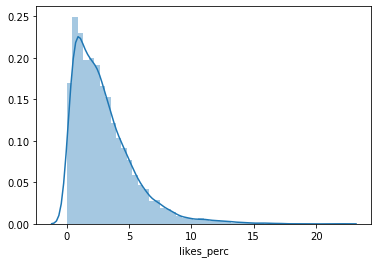

In [6]:
# Número de likes relativas - percent

df_last['likes_perc'] =(df_last['likes']/df_last['views'])*100
df_last['likes_perc'].sort_values(ascending=False).head()
mean_likes = np.mean(df_last['likes_perc'])
print('Average of relative likes: ', mean_likes)

_ = sns.distplot(df_last['likes_perc'])

Average of relative dislikes:  0.15935640471726029


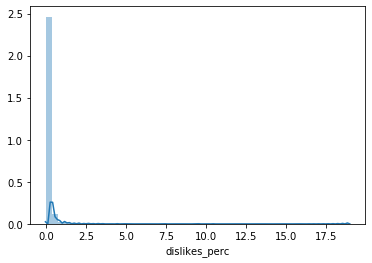

In [7]:
# Número de dislikes relativas - percent

df_last['dislikes_perc'] =(df_last['dislikes']/df_last['views'])*100
df_last['dislikes_perc'].sort_values(ascending=False).head()
mean_dislikes = np.mean(df_last['dislikes_perc'])
print('Average of relative dislikes: ', mean_dislikes)

_ = sns.distplot(df_last['dislikes_perc'])

Average of relative comments:  0.4051785150755059


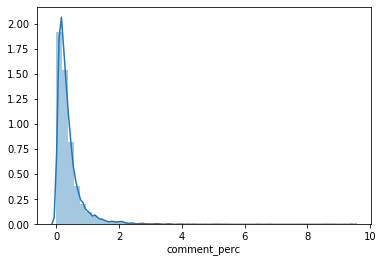

In [8]:
# Número de discussões relativas (quantidade de comentários)

df_last['comment_perc'] =(df_last['comment_count']/df_last['views'])*100
df_last['comment_perc'].sort_values(ascending=False).head()
mean_comment = np.mean(df_last['comment_perc'])
print('Average of relative comments: ', mean_comment)

_ = sns.distplot(df_last['comment_perc'])

1962117.2407494884


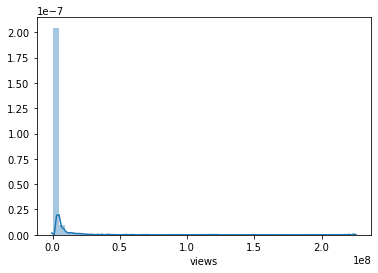

In [9]:
mean_visu = np.mean(df_last.views)
print(mean_visu)
_ = sns.distplot(df_last.views)

De acordo com as distribuições, percebe-se que mesmo entre os trend videos, poucos usuários registram sua opinião sobre o vídeo. Iremos supor preliminarmente 4 categorias: 'loved', 'hated', 'polemic', 'neutral'

* **Loved**: videos com alta porcentagem relativa de curti e baixa de não curti.
* **Hated**: videos com baixa porcentagem relativa de curti e alta de não curti
* **Polemic**: ambas porcentagens relativas altas.
* **Neutral**: ambas porcentagens relativas baixas

In [0]:
df_last.loc[(df_last['likes_perc'] >= mean_likes) & (df_last['dislikes_perc'] < mean_dislikes), 'emotion'] = 'loved' 
df_last.loc[(df_last['likes_perc'] < mean_likes) & (df_last['dislikes_perc'] >= mean_dislikes), 'emotion'] = 'hated' 
df_last.loc[(df_last['likes_perc'] >= mean_likes) & (df_last['dislikes_perc'] >= mean_dislikes), 'emotion'] = 'polemic' 
df_last.loc[(df_last['likes_perc'] < mean_likes) & (df_last['dislikes_perc'] < mean_dislikes), 'emotion'] = 'neutral'

In [11]:
#Apresentando os valores referentes à nova coluna "emotion"
df_last.emotion.value_counts()

neutral    2917
loved      1956
hated       913
polemic     565
Name: emotion, dtype: int64

In [12]:
df_last.loc[df_last.emotion== 'hated', :].head(2)

,,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,description,likes_perc,dislikes_perc,comment_perc,emotion
video_id,,,,,,,,,,,,,,,,,
-2b4qSoMnKE,7431,-2b4qSoMnKE,2017-12-21,Ex-UFO program chief: We may not be alone,CNN,25,2017-12-19T20:46:33.000Z,"latest News|""Happening Now""|""CNN""|""luis elizon...",291653,3788,603,3093,"Luis Elizondo, a former military intelligence ...",1.298804,0.206753,1.060507,hated
-El8z4uy5Ac,2507,-El8z4uy5Ac,2017-11-26,The Best Movie Hell to End Up In - After Hours,Cracked,23,2017-11-20T17:00:00.000Z,"movie hells|""hercules""|""bedazzled""|""all dogs g...",639982,16519,1243,1739,The gang gets together for a frank discussion ...,2.581166,0.194224,0.271726,hated


In [13]:
df_last.loc[df_last.emotion== 'polemic', :].head(2)

,,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,description,likes_perc,dislikes_perc,comment_perc,emotion
video_id,,,,,,,,,,,,,,,,,
-5aaJJQFvOg,21947,-5aaJJQFvOg,2018-03-05,Havana - swing cover | dodie feat. FLASHBACK,doddleoddle,10,2018-02-21T22:01:06.000Z,"havana|""cover""|""a capella""|""swing""|""dodie""|""fl...",1168351,135280,1917,6282,Hi hi hi! here's our vid on FLASHBACK's channe...,11.578712,0.164077,0.537681,polemic
-V1Oo7srGf0,15909,-V1Oo7srGf0,2018-02-03,YOUR DATE IS HERE - Horror Short,Midnight Video,1,2018-01-29T13:00:00.000Z,"horror|""horror short""|""short""|""short film""|""my...",70891,5155,129,781,After dusting off an old Mystery Date-style bo...,7.271727,0.181970,1.101691,polemic


In [14]:
df_last.loc[df_last.emotion== 'loved', :].head(2)

,,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,description,likes_perc,dislikes_perc,comment_perc,emotion
video_id,,,,,,,,,,,,,,,,,
-1yT-K3c6YI,3711,-1yT-K3c6YI,2017-12-02,YOUTUBER QUIZ + TRUTH OR DARE W/ THE MERRELL T...,Molly Burke,22,2017-11-28T18:30:43.000Z,"youtube quiz|""youtuber quiz""|""truth or dare""|""...",231341,7734,212,846,Check out the video we did on the Merrell Twin...,3.343117,0.091640,0.365694,loved
-35jibKqbEo,19745,-35jibKqbEo,2018-02-22,Kygo - Stranger Things ft. OneRepublic (Alan W...,Alan Walker,10,2018-02-14T17:00:49.000Z,"Alan Walker|""Kygo""|""One Republic""|""Stranger Th...",2425578,129381,1522,8757,"Happy Valentines Day, Walkers!\n\nI made a rem...",5.334028,0.062748,0.361027,loved


In [0]:
# Adicionando coluna categorizando os videos em populares "1" (>= 1 milhao de views), ou não populares "0" (< 1 milhao)
df_last['pop'] = 0
df_last.loc[df_last.views >= 1e6, ['pop']] = 1



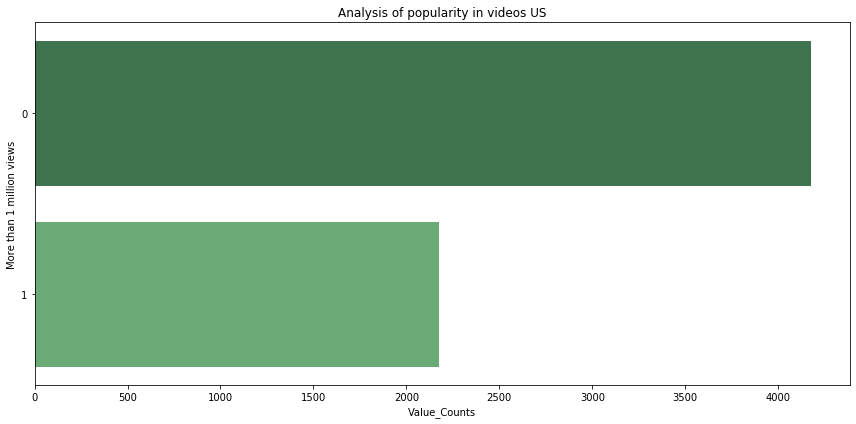

In [19]:
# Plot da distribuição da popularidade dos vídeos 

plt.figure(figsize=(12,6))

sns.countplot(y='pop', data=df_last, palette='Greens_d')
plt.xlabel('Value_Counts')
plt.ylabel('More than 1 million views')
plt.title('Analysis of popularity in videos US')
plt.tight_layout()
plt.show()

In [0]:
#Salvando dataset processado para outras análises 
df_last.to_csv('sentiments.csv', index=False)

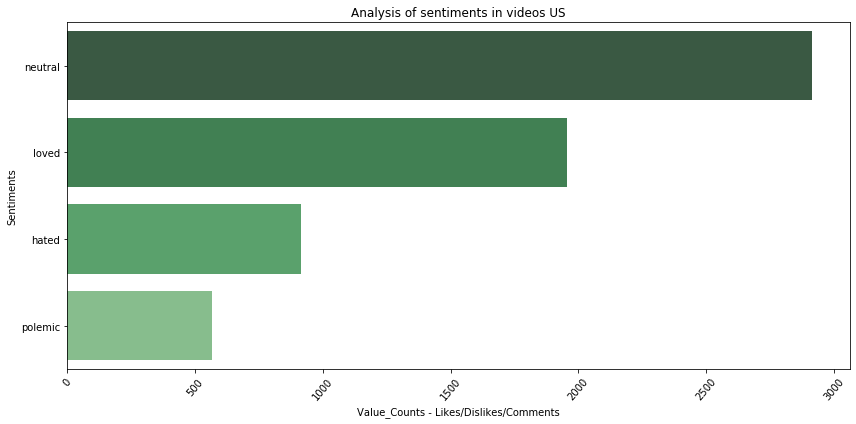

In [17]:
# Plot da distribuição dos sentimentos em relação aos vídeos 

plt.figure(figsize=(12,6))

sns.countplot(y='emotion', data=df_last, palette='Greens_d', order=df_last['emotion'].value_counts().index)
plt.xticks(rotation=50)
plt.xlabel('Value_Counts - Likes/Dislikes/Comments')
plt.ylabel('Sentiments')
plt.title('Analysis of sentiments in videos US')
plt.tight_layout()
plt.show()

# **Conclusão**

Realizamos uma análise sobre a distribuição de variáveis dos vídeos que potencialmente indicariam emoções por parte dos usuários. Observamos que mesmo entre os top vídeos (+ 200 milhões) de visualizações a quantidade de curtidas e não curtidas é proporcionalmente muito baixa em relação ao de visualizações. Por exemplo, em média menos de 3% das visualizações geram curtidas. 

Isto indica que por si só elas não são confiáveis para apontar sentimentos, precisando de suporte de outras variáveis para caracterizar emoções que infelizmente não temos disponíveis no dataset.

Esta desproporção é ainda mais forte em emoções negativas, pois em média 0.15% das visualizações de um vídeo geram não curtidas. 

Tentamos criar features targets para posterior uso em algoritmos de classificação, binário (popular ou não) e multi-classe (4 tipos de emoções). Observamos pelo gráfico de barras uma desproporção na distribuição dos dados nas classes, indicando fortemente a necessidade de um pré-processamento de balanceamento.

Por estas razões, os resultados dos modelos classificadores de sentimentos foram muito ruins, mesmo explorando técnicas de diversas famílias. Nas métricas os falsos positivos eram altos, indicando um enviesamento do modelo pela classe mais comum, mesmo ao aplicar balanceamento de classe.
